In [1]:
using Pkg

In [2]:
Pkg.activate(dirname(pwd()))

  Activating environment at `~/Documents/GitHub/ComputationalHeatTransfer.jl/Project.toml`


In [3]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using CoolProp
using Interpolations
using JLD2
using Plots
gr()  

cd(dirname(pwd()))
cd("src") 
# includet("ComputationalHeatTransfer.jl")
# using ..ComputationalHeatTransfer
includet("OneDOHP.jl")
using ..OneDOHP

## Get fluid properties

In [4]:
fluid_type = "butane"
Tᵥ = 291.2

291.2

In [5]:
using UnPack

p_fluid = get_saturation_property(fluid_type,Tᵥ)
@unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

## Read data

In [6]:
using JLD2

In [184]:
OHPdata = load("OHP1_30W_E063_2_DT1_small.jld2")

Dict{String, Any} with 6 entries:
  "integrator_tube"  => t: 49.99999999991015…
  "integrator_plate" => t: 50.00019999991015…
  "ohp"              => Basic pointwise-specified body with 4877 points…
  "tube_hist"        => Any[t: 0.4997999999999776…
  "plate_T_hist"     => Any[Primal nodes in a (nx = 250, ny = 108) cell grid of…
  "boil_data"        => [94.0 0.1; 146.0 0.1; … ; 50.0 50.0; 213.0 50.0]

In [185]:
tube_hist = OHPdata["tube_hist"]
plate_T_hist = OHPdata["plate_T_hist"]
# plate_hist = load("plate_OHP1_40W.jld2")
integrator_plate = OHPdata["integrator_plate"]
sys = integrator_plate.p

sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

## Get RTD result for OHP

In [186]:
import XLSX

In [187]:
# xf = XLSX.readxlsx("20190613_F_PD_#004_O001_H001_P040_expA.xlsx")
# starti = 3603
# RTD = xf["Raw Data!G:N"][starti:end,:];
# RTDt = (1:size(RTD,1)) .+ starti;

In [188]:
xf = XLSX.readxlsx("20190612_F_PD_#007_O002_H001_P030_expA.xlsx")
# xf = XLSX.readxlsx("20190613_F_PD_#008_O002_H001_P040_expA.xlsx")
starti = 3603
# RTD = xf["Raw Data!G:N"][starti:end,:];
RTD = xf["Raw Data!U:AB"][starti:end,:];
RTDt = (1:size(RTD,1)) .+ starti;

In [189]:
inch = 2.54e-2;


# x = [-2.6inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
x = [-2.75inch,-1.4inch,-0.8inch,0.0,0.0,0.8inch,1.4inch,2.75inch]
y = [0.0,0.0,0.0,0.0,0.4inch,0.0,0.0,0.0];

## get and save temperature line graph

In [190]:
X =  VectorData(x,y);

In [191]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [192]:
ghist = []
thist = []

size(g)
for j = 1:length(g)
    gtemp = []
    for i = 1:length(plate_T_hist)
        H(g,plate_T_hist[i])
        append!(gtemp,deepcopy(g[j]))
    end
    push!(ghist,deepcopy(gtemp))
end



thist = []
    for i = 1:length(tube_hist)
        append!(thist,tube_hist[i].t)
    end

30

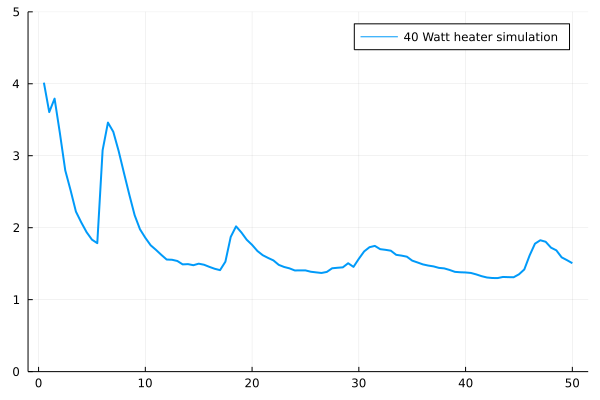

In [195]:
power = 30
i1 = 4 #RTD number
i2 = 8 #RTD number
conductance = power ./ (ghist[i1] .-ghist[i2])

plot(thist,conductance ,label=string("40 Watt heater simulation"),linewidth=2,ylim=(0,5))

## Dryness

In [196]:
function getwetness(sysarray)
    wetness = Float64[]
    for sysfinali in sysfinal
        Lvaporplug = XptoLvaporplug(sysfinali.liquid.Xp,sysfinali.tube.L,sysfinali.tube.closedornot)
        Lvaporsum = sum(Lvaporplug)
        Ldryvapor = Lvaporplug - sysfinali.vapor.Lfilm_start  - sysfinali.vapor.Lfilm_end
        Ldrysum = sum(Ldryvapor)

        push!(wetness, 1 - Ldrysum/Lvaporsum)
    end
    
    wetness
end

getwetness (generic function with 1 method)

In [199]:
wetness = getwetness(sysfinal);

In [201]:
function getV(sysarray)
    Vabs_avg = Float64[]
    Vabs_max = Float64[]
    
    V = [elem[2] for elem in sysfinali.liquid.dXdt]
    Vavg = mean(abs.(V))
    Vmax = maximum(abs.(V))
    
    push!(Vabs_avg, Vavg)
    push!(Vabs_max, Vmax)
    Vabs_avg,Vabs_max
end

getV (generic function with 1 method)

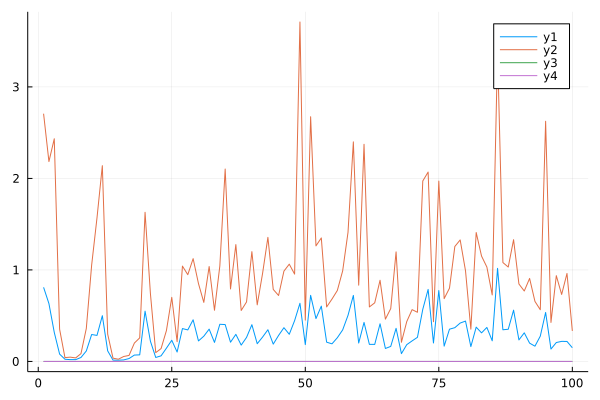

In [202]:
Vabs_avg = Float64[]
Vabs_max = Float64[]
δ_avg_start = Float64[]
δ_avg_end = Float64[]
for sysfinali in sysfinal
    V = [elem[2] for elem in sysfinali.liquid.dXdt]
    Vavg = mean(abs.(V))
    Vmax = maximum(abs.(V))
    
    δstart = sysfinali.vapor.δstart
    δend = sysfinali.vapor.δend
    
    push!(Vabs_avg, Vavg)
    push!(Vabs_max, Vmax)
    push!(δ_avg_start, mean(δstart))
    push!(δ_avg_end, mean(δend))
end

plot(Vabs_avg)
plot!(Vabs_max)
plot!(δ_avg_start)
plot!(δ_avg_end)

## interface velocity curve

In [174]:
using Statistics

In [175]:
# mean(Vabs_avg[40:end]) 10w

In [176]:
# mean(Vabs_avg[40:end]) 20w

In [179]:
# mean(Vabs_avg[40:end]) 30w

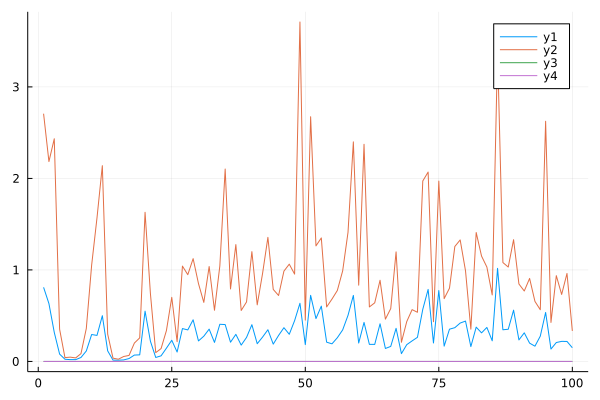

In [180]:
Vabs_avg = Float64[]
Vabs_max = Float64[]
δ_avg_start = Float64[]
δ_avg_end = Float64[]
for sysfinali in sysfinal
    V = [elem[2] for elem in sysfinali.liquid.dXdt]
    Vavg = mean(abs.(V))
    Vmax = maximum(abs.(V))
    
    δstart = sysfinali.vapor.δstart
    δend = sysfinali.vapor.δend
    
    push!(Vabs_avg, Vavg)
    push!(Vabs_max, Vmax)
    push!(δ_avg_start, mean(δstart))
    push!(δ_avg_end, mean(δend))
end

plot(Vabs_avg)
plot!(Vabs_max)
plot!(δ_avg_start)
plot!(δ_avg_end)

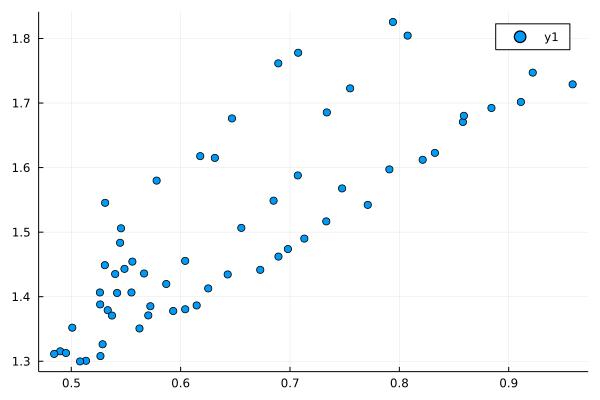

In [183]:
# scatter(Vabs_max,wetness,ylim=(0.5,1),xlim=(0,1.5))
scatter(wetness[40:end],conductance[40:end])

In [143]:
V = [elem[2] for elem in sysfinal[end-5].liquid.dXdt]
Vavg = sum(abs.(V))/length(V)

0.10445281640710967

In [82]:
addindex = 50:1:100
VArray = []
for i in addindex
VArray = [VArray;[elem[2] for elem in sysfinal[i].liquid.dXdt]]
end

## film δ distribution

In [ ]:
addindex = 50:1:300
δArray = []
for i in addindex
δArray = [δArray;sysfinal[i].vapor.δ]
end

In [ ]:
histogram(δArray,bins=2.0e-5:0.25e-6:3.0e-5,title="sum of δ from 50[s] : 1[s] : 100[s]",legend=false,xlabel="δ [m]",ylabel="N of vapor") 

In [ ]:
savefig("sum_film_thickness.svg")

In [ ]:
sysfinal[end].vapor.δ

In [ ]:
l = @layout [a b ; c d]
pltindex=[5,25,100,300]
p1 = histogram(sysfinal[pltindex[1]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[1]].t, digits=2), "[s]")) 
p2 = histogram(sysfinal[pltindex[2]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[2]].t, digits=2), "[s]")) 
p3 = histogram(sysfinal[pltindex[3]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[3]].t, digits=2), "[s]")) 
p4 = histogram(sysfinal[pltindex[4]].vapor.δ,bins=2.5e-5:0.25e-6:3.5e-5,ylim=(0,20),title=string("t=",round(tube_hist[pltindex[4]].t, digits=2), "[s]")) 
plot(p1, p2, p3, p4, layout = l,titlefontsize=10,labelfontsize=10,xticks=2.5e-5:0.5e-5:3.5e-5,legend=false,xlabel="δ [m]",ylabel="N of vapor",plot_title="film thickness histogram")

In [ ]:
savefig("film_histogram.pdf")